# Exemplo 3: MNIST Vision Transformer (VT)

**Nível de dificuldade:** <font color=red>avançado</font>

:::{warning}

Este modelo é significativamente maior que os demais. Deste modo, treina-lo demora horas, ao invés de minutos.
Para comparação, a tabela a seguir mostra o número de parâmetros treináveis de cada modelo criado:

|    **Modelo**    | **Parametros** | **Parametros treináveis** | **Tamanho relativo** |
|:----------------:|:--------------:|:-------------------------:|:--------------------:|
|      **VST**     |   21.662.157   |         21.662.154        |         <b><font color=red>622x</font></b>         |
|    **Conv2D**    |     34.826     |           34.826          |          1x          |
| **Feed-forward** |     409.405    |          409.405          |          11x         |

:::

# Importando as bibliotecas necessárias

Para o exemplo em questão, serão utilizadas as seguintes bibliotecas:

- [Matplotlib](https://matplotlib.org/stable/index.html#installation)
- [Numpy](https://numpy.org/install/)
- [Tensorflow](https://www.tensorflow.org/install)
- [tensorflow-addons](https://www.tensorflow.org/addons/overview)


```{tip}
Acesse os links listados acima, para maiores informações de como instalar as bibliotecas que serão utilizadas.
```

In [1]:
!pip install numpy tensorflow matplotlib tensorflow-addons

## Importando pacotes necessários

In [1]:
from __future__ import annotations
from typing import List, Any, Tuple, Iterable

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

# Obtendo os dados do problema

A próxima linha de código realiza o download dos dados a serem utilizados.
A base será salva dentro do diretório `data/MNIST`.

:::{note}
As bases serão baixadas apenas uma vez. Execuções subsequentes carregarão o arquivo salvo em: `data/MNIST/mnist.npz`.
:::

**Fonte dos dados:** [MNIST homepage](http://yann.lecun.com/exdb/mnist/)

**Função:** keras.datasets.mnist.load_data(path='mnist.npz')

**Descrição:** Baixa e carrega o dataset MNIST.

**Retorna:** tupla de tuplas de arrays [NumPy](https://numpy.org/doc/stable/user/quickstart.html), com os seguintes objetos: `(x_train, y_train), (x_test, y_test)`. Onde:


- `x_train (np.ndarray[60000, 28, 28])`: 60.000 arrays de tamanho 28x28, representando o conjunto de imagens a serem utilizadas para treino do modelo.
- `y_train (np.ndarray[60000])`: 60.000 labels, com valores entre 0 e 9, representando cada um dos dígitos de `x_train`.
- `x_test (np.ndarray[10000, 28, 28])`: 10.000 arrays de tamanho 28x28, representando o conjunto de imagens a serem utilizadas para teste do modelo.
- `y_test (np.ndarray[10000])`: 10.000 labels, com valores entre 0 e 9, representando cada um dos dígitos de `x_test`.

In [2]:
data_dir = Path.cwd().joinpath(r'data/MNIST')
data_dir.mkdir(parents=True, exist_ok=True)
mnist_fpath = data_dir.joinpath('mnist').with_suffix('.npz')

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path=str(mnist_fpath))

In [4]:
# Convertendo dimensão das imagens para: (784, 1)
x_train_norm = x_train.reshape(-1, 28, 28, 1)
x_test_norm = x_test.reshape(-1, 28, 28, 1)
y_train = y_train.reshape(-1, 1)

print(f"x_train shape: \033[94m\033[1m{x_train_norm.shape}\033[0m")
print(f"Quantidade de imagens a serem utilizadas durante o treino: \033[94m\033[1m{x_train_norm.shape[0]:,} imagens\033[0m")
print(f"Quantidade de imagens a serem utilizadas durante o teste: \033[94m\033[1m{x_test_norm.shape[0]:,} imagens\033[0m")

x_train shape: (60000, 28, 28, 1)
Quantidade de imagens a serem utilizadas durante o treino: 60,000 imagens
Quantidade de imagens a serem utilizadas durante o teste: 10,000 imagens


# Criando o modelo

## Configurando Híperparametros

In [5]:
input_shape = tuple(x_train_norm.shape[1:])

learning_rate = 0.001
weight_decay = 0.0001

batch_size = 256
num_epochs = 100

image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images

num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 4

# Size of the transformer layers
transformer_units = [projection_dim * 2, projection_dim]

transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train_norm)

In [7]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


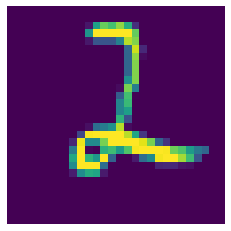

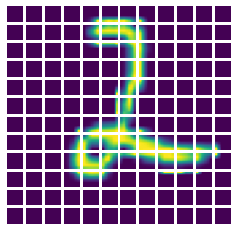

In [8]:
plt.figure(figsize=(4, 4))

image = x_train_norm[np.random.choice(range(x_train_norm.shape[0]))]

plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
input_shape = tuple(x_train_norm.shape[1:])

learning_rate = 0.001
weight_decay = 0.0001

batch_size = 256
num_epochs = 100

image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images

num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 4

# Size of the transformer layers
transformer_units = [projection_dim * 2, projection_dim]

transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
def create_vit_classifier(
    input_shape: tuple | None = None,
    image_size: int = 72,
    patch_size: int = 6,
    projection_dim: int = 64,
    num_heads: int = 4,
    transformer_layers: int = 8,
    transformer_units: List[int] | None = None,
    mlp_head_units: List[int] | None = None,
    num_classes : int = 10,
    
):
    """Create Vision Transformer (VIT) classifier model.

    Parameters
    ----------
    input_shape : tuple, optional
        The shape of the input data. Defaults to (28, 28, 1).
    image_size : int, optional
        Resize input images to this size. Defaults to 72 (72 by 72).
    patch_size : int, optional
        Size of the patches to be extract from the input images.
        Defaults to 6 (6 by 6).
    projection_dim : int, optional
        The dimension of the projection. Defaults to 64.
    num_heads : int, optional
        The number of heads in the multi-head attention layer.
        Defaults to 4.
    transformer_layers : int, optional
        The number of transformer layers. Defaults to 8.
    transformer_units : List[int] | None, optional
        Size of the transformer layers. 
        Defaults to [`projection_dim` * 2, `projection_dim`].
    mlp_head_units : List[int] | None, optional
        Size of the dense layers of the final classifier.
        Defaults to [2048, 1024].
    num_classes : int, optional
        The number of classes from the target layer. Defaults to 10.

    Returns
    -------
    keras.Model
        The Vision Transformer classifier.
    """
    num_patches = (image_size // patch_size) ** 2
    
    if input_shape is None:
        input_shape = (28, 28, 1)
    if transformer_units is None:
        transformer_units = [projection_dim * 2, projection_dim]
    if mlp_head_units is None:
        mlp_head_units = [2048, 1024]
    inputs = layers.Input(shape=input_shape)
    
    # Augment data.
    augmented = data_augmentation(inputs)
    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model


In [12]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 1)   3           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 36)     0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches_1[0][0]']              
                                                                                              

In [13]:

def run_experiment(model):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train_norm,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 1.1037 - accuracy: 0.7046 - top-5-accuracy: 0.9536


KeyboardInterrupt



In [29]:
%load_ext tensorboard

In [100]:
log_dir = Path(f"./logs/mnist-fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
log_dir.mkdir(parents=True, exist_ok=True)

Epoch 1/15
469/469 [==============================] - 3s 6ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 0.0120 - val_accuracy: 0.9973
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 3/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 4/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0044 - val_accuracy: 0.9987
Epoch 5/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0019 - val_accuracy: 0.9993
Epoch 7/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 

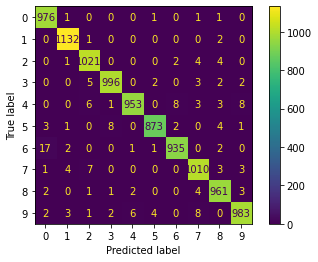

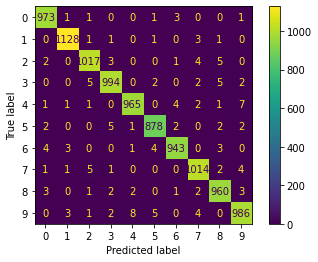

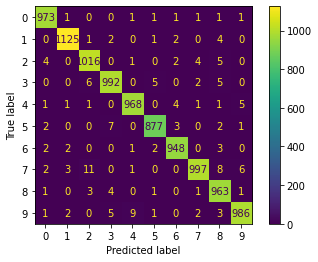

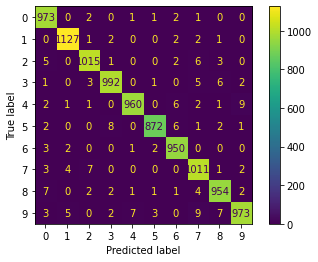

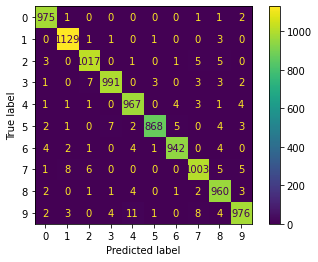

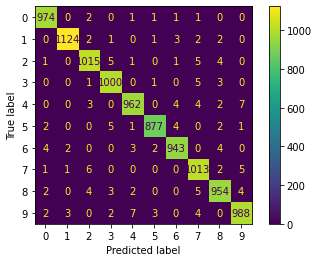

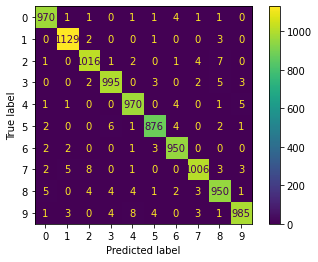

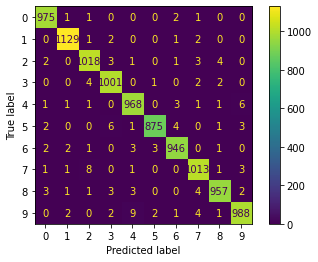

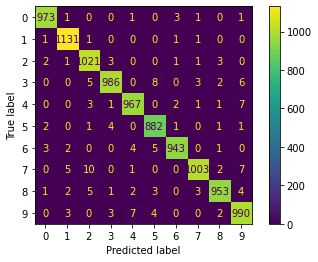

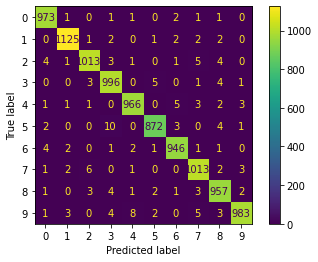

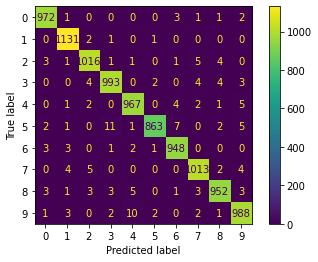

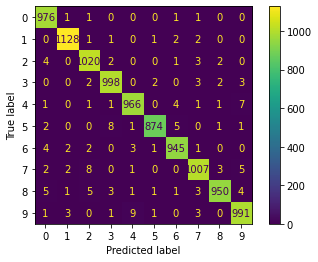

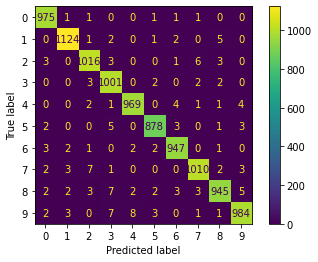

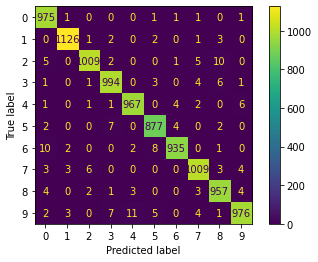

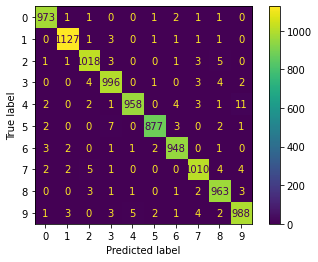

In [109]:
model.fit(
    x_train_norm, 
    y_train_norm,
    batch_size=batch_size, 
    epochs=epochs, 
    # validation_split=0.1, 
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(x_test_norm, y_test_norm),
)

In [110]:
log_dir

PosixPath('logs/mnist-fit/20220418-022041')

# Avaliando o modelo

Agora que treinamos o nosso modelo, podemos avaliar a sua real acurácia, introduzindo dados nunca antes vistos pelo modelo.
Essa etapa é extremamente importante, para avaliarmos se o modelo durante o treino foi capaz de inferir as características que fazem
o dígito 5, ser 5, ou um 4, ser 4, etc.

In [113]:
score = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f"Acurácia do modelo: {score[1]:.2%}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0832 - accuracy: 0.9858
Acurácia do modelo: 98.58%


**Opção 2:** Tensorboard

In [51]:
score = model.evaluate(x_test_norm, y_test_norm, verbose=1, callbacks=[tensorboard_callback, cm_callback])
print(f"Acurácia do modelo: {score[1]:.2%}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0816 - accuracy: 0.9847
Acurácia do modelo: 98.47%


## Criando função `predict_img`

A função `predict_img` utiliza o modelo treinado para prever uma imagem ou lista de imagens.
Ela também utiliza a função `plot_imgs` criada anteriormente para visualizar as imagens.

In [34]:
def plot_imgs(
    imgs: List[np.ndarray],
    labels: List[Any] | None = None,
    labels_prefix: str | None = None,
    cols: int = 5,
    figsize: Tuple[int, int] | None = None, 
    maxsize: int = 30,
    cmap: str = 'gray',
) -> None:
    """Plot array of images. 
    
    Parameters
    ----------
    imgs: List[np.ndarray]
        List of images.
    labels: List[Any] | None, optional
        List of labels for each image. If no label is specified,
        then each figure is plotted without label.
    cols: int, optional
        Number of columns to plot. Defaults to 5.
    figsize: Tuple[int, int], optional
        Figure size. If no value specified, then function
        uses `figsize = (12, 3 * rows)`.
    maxsize: int, optional
        Maximum number of images to plot.
    cmap: str, optional
        Colormap of each plot. Defaults to "gray".
    """
    if imgs.ndim == 2:
        imgs = [imgs]
    if labels_prefix is None:
        labels_prefix = 'Label:'

    num_imgs = len(imgs)
    maxsize = min(num_imgs, maxsize)
    rows = int(np.ceil(maxsize/cols))
    cols = min(cols, num_imgs)

    if figsize is None:
        figsize = (12, 3 * rows)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    current_col = 0
    current_row = -1
    
    for i, img in enumerate(imgs[:maxsize]):
        
        _current_col = i // cols
        
        if current_col != _current_col:
            current_row = 0
            current_col += 1
        else:
            current_row += 1
        if rows <= 1:
            ax = axes[current_row] 
        else:
            ax = axes[current_col, current_row]
        
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        
        if labels is not None and len(labels) >= i + 1:
            curr_label = f'{labels_prefix.rstrip(" ")} {labels[i]}'
            ax.set_title(
                curr_label, 
                fontsize=int((105*(figsize[0]/cols))/max(14, len(curr_label))),
            )

    plt.show()


def predict_img(
    img: Iterable | np.ndarray, 
    model: keras.engine.functional.Functional,
    real_label: Iterable | str | int | None = None,
    plot_results: bool = True,
    sample_size: int | None = None,
):
    """
    Predict the label of an image or array of images.
    
    Function also normalizes images, if they're not normalized already.
    
    Parameters
    ----------
    img : Iterable | np.ndarray
        The image to predict.
    model : keras.engine.functional.Functional
        The model used to predict the image.
        If None, a ValueError will be raised.
    real_label : Iterable | str | int | None, default: None
        The real label of the image.
        If not None, the predicted label will be displayed next to the real one.
    plot_results: bool, default: True
        Whether to plot the image(s).
    sample_size: int | None, default: None
        If specified, selects this amount of examples randomly and plots them.

    Returns
    -------
    preds : List[int]
        The predicted label, or labels of the image(s).

    Raises
    ------
    ValueError
        If the model is None.

    Examples
    --------
    You can use this function as follows:

    .. code-block:: python

        # predicts and plots the first five images from test dataset.
        predict_img(x_test[0:5], y_test[0:5], model)
        
        # predicts the first five images from test dataset.
        predict_img(x_test[0:5], y_test[0:5], model, plot_results=False)
        
        # predicts and plots the first five images from normalized test dataset.
        predict_img(x_test_norm[0:5], y_test[0:5], model)

    """
    if model is None:
        raise ValueError('You need to pass the trained model to the \"model\" argument')
    if isinstance(sample_size, int):
        take_samples = min(len(img), sample_size)
        if not take_samples == sample_size:
            print(
                f'The number of samples you\'re trying to plot ({sample_size}) is greater than the array of '
                f'examples you\'re trying to plot. Selecting {take_samples} samples instead.'
            )
        indexes = range(0, len(img)-1)
        random_indexes = random.sample(indexes, take_samples)
        img = np.array([img[index] for index in random_indexes])
        if isinstance(real_label, Iterable) and len(real_label) == len(img):
            real_label = [real_label[index] for index in random_indexes]
    _img = img
    if not img.ndim == 4:
        img = img.reshape(-1, 28, 28, 1)
    preds = model.predict(img)
    preds = [np.argmax(pred) for pred in preds]
    if plot_results:
        if isinstance(real_label, Iterable) and len(real_label) == len(preds):
            labels_prefix = 'Real Label:'
            labels = [f'{real_lbl} / Pred: {pred}' for real_lbl, pred in zip(real_label, preds)]
        else:
            labels = preds
            labels_prefix = 'Predicted Label:'
        plot_imgs(_img, labels, labels_prefix)

    return preds

In [30]:
from typing import Iterable
import random


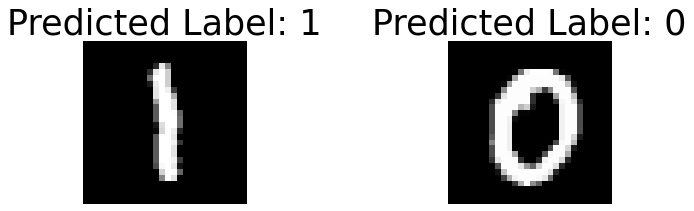

[1, 0]

In [47]:

predict_img(x_test, m, y_test, sample_size=2)

## Erros do modelo

In [332]:
predictions = predict_img(x_test, model=model, plot_results=False)

In [333]:
false_predictions = [
    idx for idx, (true_label, predicted_label) in enumerate(zip(y_test, predictions))
    if true_label != predicted_label
]
print(
    f'Modelo errou: {len(false_predictions):,} de {len(y_test):,} ({len(false_predictions)/len(y_test):.2%})'
)

Modelo errou: 76 de 10,000 (0.76%)


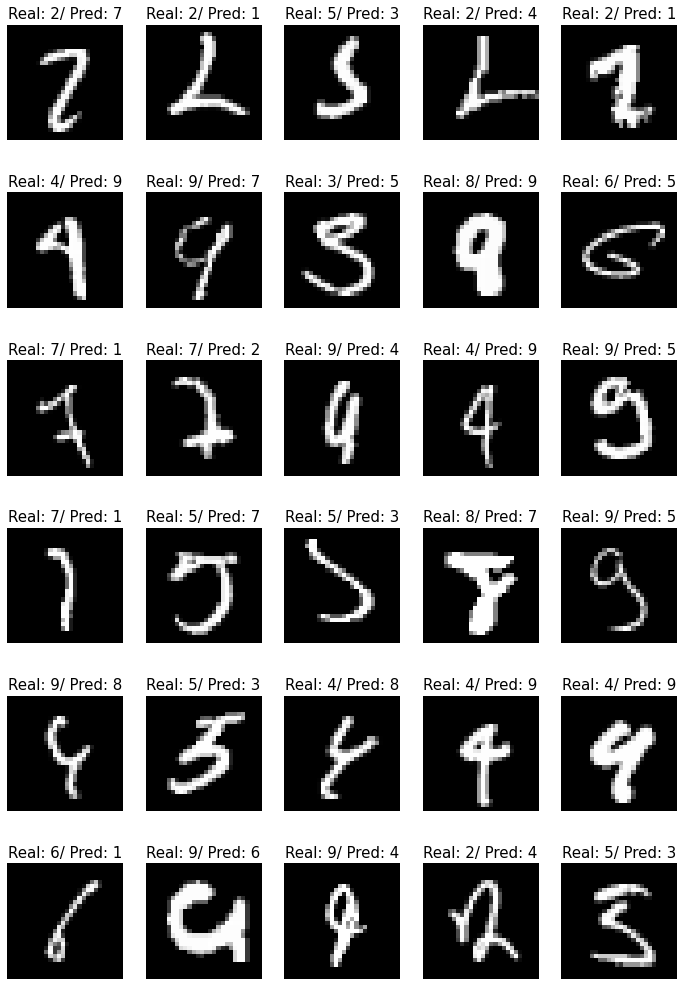

In [334]:
false_preds = predict_img(x_test_norm[false_predictions], y_test[false_predictions], model)

In [16]:
m = keras.models.load_model('models/mnist-VIT')

# Conclusão

O modelo criado foi capaz de aprender com alta acurácia, a reconhecer dígitos escritos à mão.


Como observado em [Erros do modelo](#Erros-do-modelo), as imagens que o nosso modelo não foi capaz de prever corretamente, seriam extremamente difíceis de serem classificadas até mesmo por um humano treinado. Isso porque, elas se assemelham bastante à outros dígitos. Sendo assim, podemos classificá-las como "outliers".